In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio
import scipy.signal
from scipy import linalg as la
from scipy import integrate as s_int
import csv
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import linear_model
import pandas as pd
import pysindy as ps
import statistics
from matplotlib import cm
from matplotlib import colors
import control
import control.matlab
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
from pysindy.differentiation import FiniteDifference
warnings.filterwarnings("ignore")

%matplotlib inline

2023-03-01 19:08:15.759565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 19:08:16.224264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 19:08:16.224304: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-01 19:08:18.265160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Dataset

In [2]:
# functions for data generation

def lorenz(t,y,sig,rho,beta):
    dx = sig*(y[1] - y[0])
    dy = y[0]*(rho - y[2]) - y[1]
    dz = y[0]*y[1] - beta*y[2]
    return [dx,dy,dz]

def rossler(t,y,a,b,c):
    dx = -y[1] - y[2]
    dy = y[0] + a*y[1]
    dz = b + y[2]*(y[0] - c)
    return [dx,dy,dz]

def financial(t,y):
    e, k, gamma ,m, l, rho, d, delta = 0.3, 0.02, 1, 1, 0.1, 0.05, 1.2, 1
    dx = d*y[2] + (y[1] - e)*y[0]
    dy = -k*y[1]**2 - l*y[0]**2 + m
    dz = -gamma*y[2] - delta*y[0] - rho*y[1]
    return [dx,dy,dz]

solver = sp.integrate.solve_ivp(fun=lambda t, y: lorenz(t,y,10,28,8/3),
                                 t_span=[0,200], t_eval=np.arange(0,200,0.001), y0=[-8,8,27], method='LSODA', 
                                 dense_output=False,rtol=1e-18,atol=1e-22)

findfont: Font family ['Century Schoolbook'] not found. Falling back to DejaVu Sans.


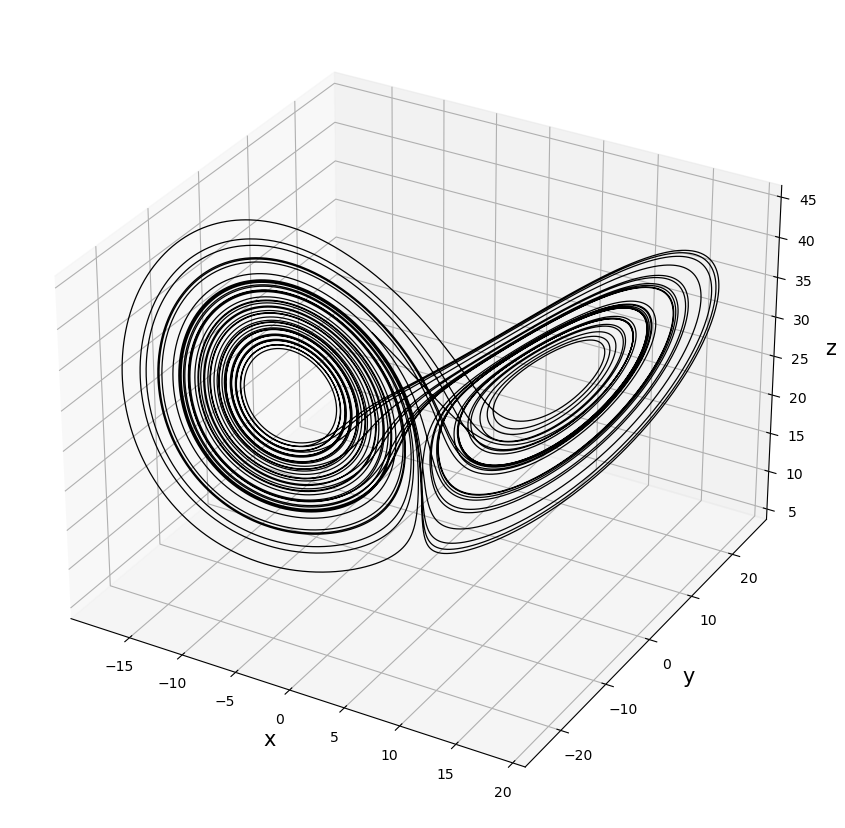

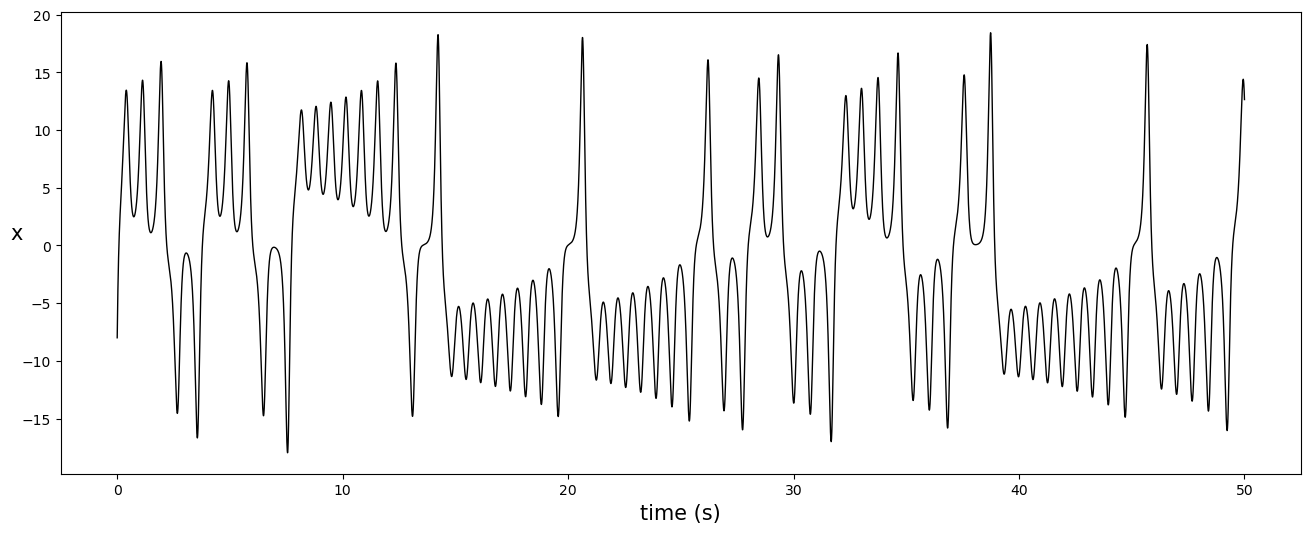

In [3]:
data_ts = solver.y.T

csfont = {'fontname' : 'Century Schoolbook', 'fontsize' : '15'}

fig = plt.figure()
fig.set_size_inches(15.5,10.5)
ax = plt.axes(projection='3d')
ax.plot3D(data_ts[:50000,0],data_ts[:50000,1],data_ts[:50000,2],c='black',lw=0.9)
ax.set_xlabel("x",**csfont)
ax.set_ylabel("y",**csfont)
ax.set_zlabel("z",**csfont)
plt.show()

x_ts = data_ts[:50000,0]
plt.figure(figsize=(16,6))
plt.plot(np.arange(0,50,0.001),x_ts,c="black",lw=1)
plt.xlabel("time (s)",**csfont)
plt.ylabel("x",**csfont,rotation=0)
plt.show()

# Hankel matrix, SVD and embadded attractor

In [4]:
l = 100
r = 15
H = np.zeros((l,len(x_ts)-l+1))
for i in range(l): H[i,:] = x_ts[i:len(x_ts)-l+i+1]
U, spectrum, Vt = la.svd(H,full_matrices=False,compute_uv=True)
print('Vt shape:',np.shape(Vt))
print(sum(spectrum[0:r])/sum(spectrum))

Vt shape: (100, 49901)
0.9999999999998741


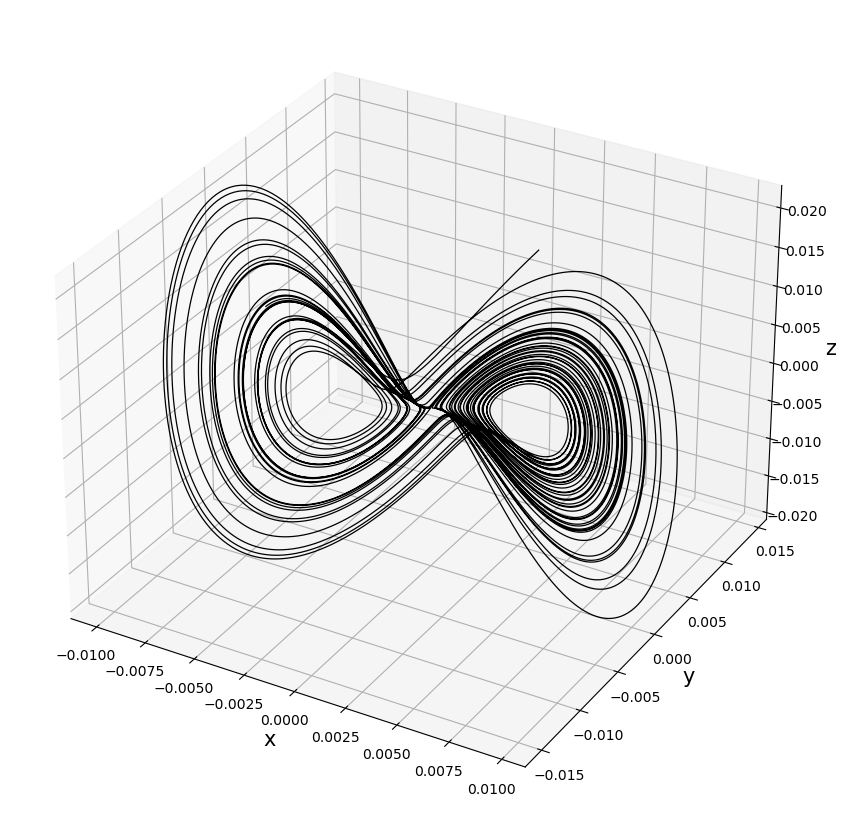

In [5]:
dt = 0.001
time = np.arange(0,len(x_ts)*dt,dt)

fig = plt.figure()
fig.set_size_inches(15.5,10.5)
ax = plt.axes(projection='3d')
ax.plot3D(Vt[0,:50000],Vt[1,:50000],Vt[2,:50000],c='black',lw=0.9)
ax.set_xlabel("x",**csfont)
ax.set_ylabel("y",**csfont)
ax.set_zlabel("z",**csfont)
plt.show()

# Sparse regression using pySindy

In [6]:
dt = 0.001
v = Vt[:r,:].T
time = np.arange(0,len(v)*dt,dt)

In [7]:
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=1)
optimizer = ps.STLSQ(threshold=0.02)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer
)

model.fit(v,t=time)

M = model.coefficients()
M = M[:,1:r+1]
A = M[:r-1,:r-1]
B = M[:r-1,r-1]

df = pd.DataFrame(np.round(M))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,-5.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,-0.0,-10.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.0,10.0,-0.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.0,13.0,-0.0,-19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-0.0,19.0,-0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,-0.0,0.0,-23.0,-0.0,-30.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,-0.0,0.0,30.0,0.0,-34.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,-0.0,-0.0,34.0,0.0,-40.0,0.0,1.0,0.0,0.0,0.0,0.0
8,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,40.0,-0.0,44.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,-0.0,-1.0,-0.0,-44.0,-0.0,-51.0,0.0,1.0,0.0,0.0


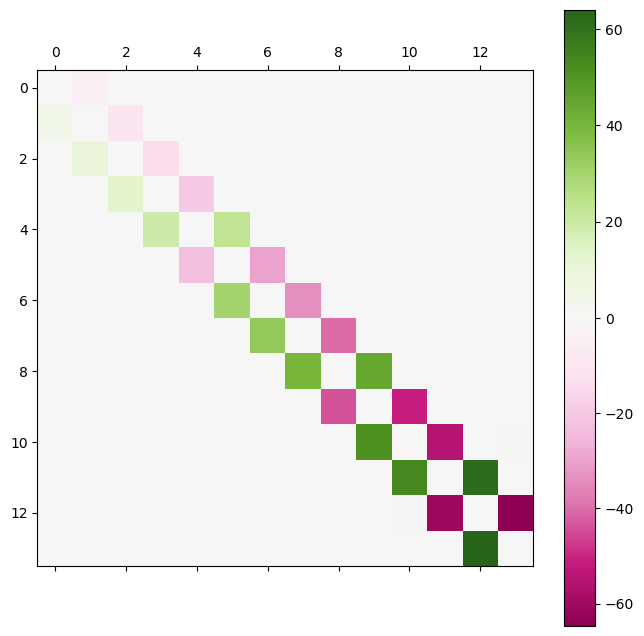

In [8]:
fig, ax = plt.subplots(figsize = (8,8))

divnorm=colors.TwoSlopeNorm(vmin=np.min(A), vcenter=0., vmax=np.max(A))
cax = ax.matshow(A, cmap= plt.get_cmap('PiYG'), norm=divnorm)
fig.colorbar(cax)

In [9]:
B = np.reshape(B,(r-1,1))
dt = 0.001
f = v[:,r-1]
xi = v[0,:r-1]
sys = control.StateSpace(A,B,np.identity(r-1),0*B)
yout,T,xout = control.matlab.lsim(sys,f,time,xi)

y1 = yout[:,0]
y2 = yout[:,1]
y3 = yout[:,2]

Text(0.5, 1.0, 'integrated eigen-time series')

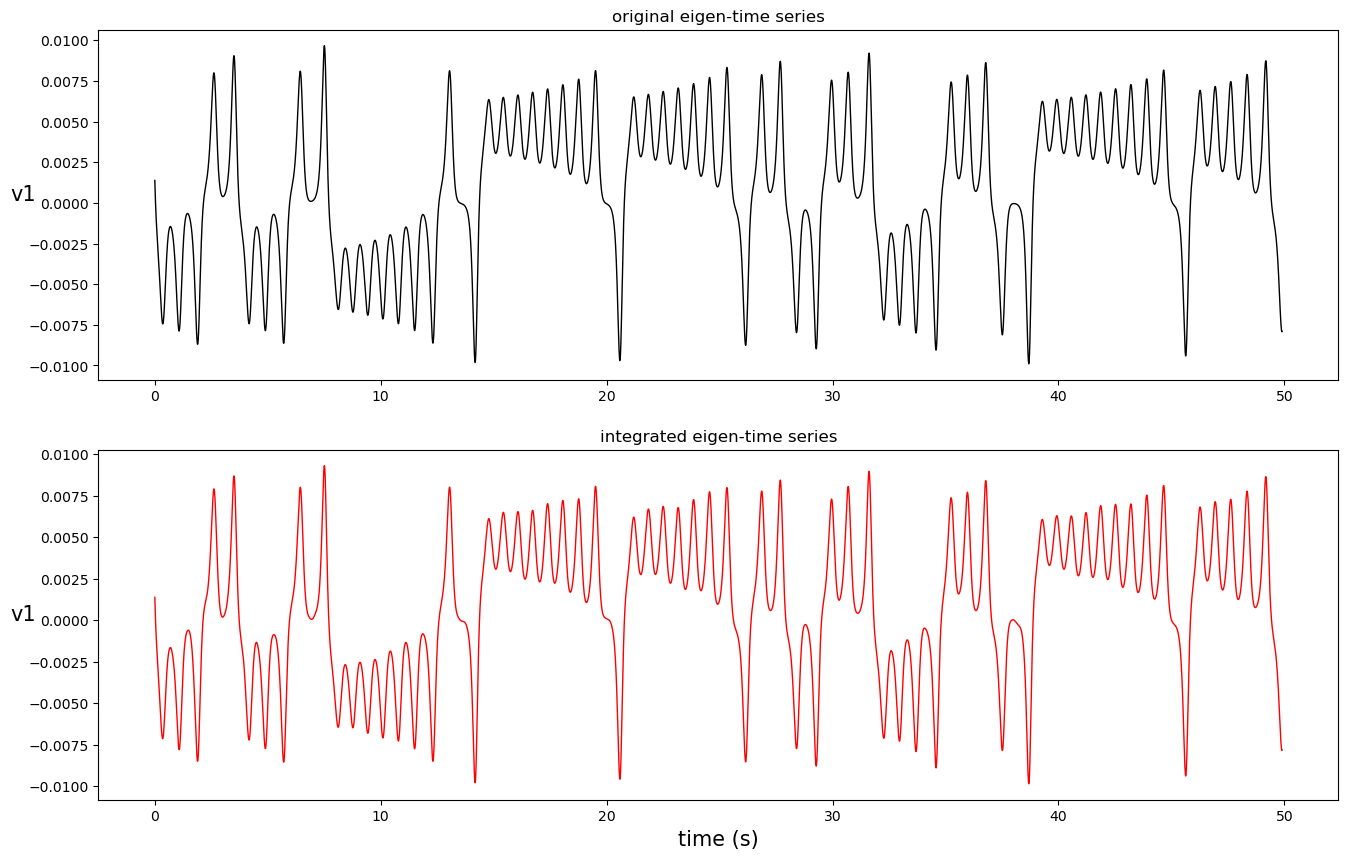

In [10]:
fig, ax = plt.subplots(2,1, figsize = (16,10))
csfont = {'fontname' : 'Century Schoolbook', 'fontsize' : '15'}
ax[1].plot(time[:50000],y1[:50000],c='red',label='integration',lw=1)
ax[0].plot(time[:50000],v[:50000,0],c='black',label='data',lw=1)
ax[1].set_xlabel('time (s)', **csfont)
ax[0].set_ylabel("v1",**csfont,rotation=0)
ax[1].set_ylabel("v1",**csfont,rotation=0)
ax[0].set_title("original eigen-time series")
ax[1].set_title("integrated eigen-time series")

### ML prediction of the time series

##### Training

In [11]:
n_train = 25000
x_train = x_ts[:n_train]
l = 100
H_train = np.zeros((l,len(x_train)-l+1))
for i in range(l): H_train[i,:] = x_train[i:len(x_train)-l+i+1]
U_train, spectrum_train, Vt_train = la.svd(H_train,full_matrices=False,compute_uv=True)
print('Vt shape:',np.shape(Vt))
print(np.sum(spectrum_train[:r])/np.sum(spectrum_train))

Vt shape: (100, 49901)
0.9999999999999145


In [12]:
v_train = Vt_train[:r,:].T
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=1)
optimizer = ps.STLSQ(threshold=0.02)

model_train = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer
)

model_train.fit(v_train,t=time[:len(v_train)])

M_train = model_train.coefficients()
M_train = M_train[:,1:r+1]
A_train = M_train[:r-1,:r-1]
B_train = M_train[:r-1,r-1]

df = pd.DataFrame(np.round(M_train))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,-5.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,-0.0,-10.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.0,10.0,-0.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.0,13.0,-0.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.0,-0.0,-0.0,19.0,-0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,-23.0,-0.0,-30.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,-0.0,0.0,30.0,0.0,-34.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,-0.0,-0.0,34.0,0.0,-40.0,0.0,1.0,0.0,0.0,0.0,0.0
8,-0.0,-0.0,-0.0,-1.0,-0.0,1.0,0.0,41.0,-0.0,44.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,-0.0,-44.0,-0.0,-52.0,0.0,1.0,0.0,0.0


##### Test

In [13]:
x_test = x_ts[n_train:n_train + 25000]
l = 100
H_test = np.zeros((l,len(x_test)-l+1))
for i in range(l): H_test[i,:] = x_test[i:len(x_test)-l+i+1]
U_test, spectrum_test, Vt_test = la.svd(H_test,full_matrices=False,compute_uv=True)

v_test = Vt_test[:r,:].T

In [14]:
B_train = np.reshape(B_train,(r-1,1))
L = 24900
f_svd = v_test[0:L,r-1]
xi_svd= v_test[0,0:r-1]
sys_svd = control.StateSpace(A_train,B_train,np.eye(r-1),0*B_train)
yout_svd,T_svd,xout_svd = control.matlab.lsim(sys_svd,f_svd,time[n_train:n_train+L],xi_svd)

y1_svd = yout_svd[:,0]
y2_svd = yout_svd[:,1]
y3_svd = yout_svd[:,2]

### Convolution (online prediction)

In [15]:
#Using the previous x_train and x_test (n_train = 50000, n_test = 50000)
q = 100
U1 = U_train[:,:r]
Vt_conv = np.zeros((r,len(x_test)-100))
for i in range(0,len(x_test)-100):
    Vt_conv[:,i] = np.dot(x_test[i:i+q],U1)

v_conv = Vt_conv[:r,:].T

In [16]:
#normalization using sigma
for i in range(r): v_conv[:,i] = v_conv[:,i]/spectrum_train[i]

f_conv = v_conv[:L,-1]
xi_conv = v_conv[0,:-1]
sys_conv = control.StateSpace(A_train,B_train,np.eye(r-1),0*B_train)
yout_conv,T_conv,xout_conv = control.matlab.lsim(sys_conv,f_conv,time[:L],xi_conv)

y1_conv = yout_conv[:,0]
y2_conv = yout_conv[:,1]
y3_conv = yout_conv[:,2]

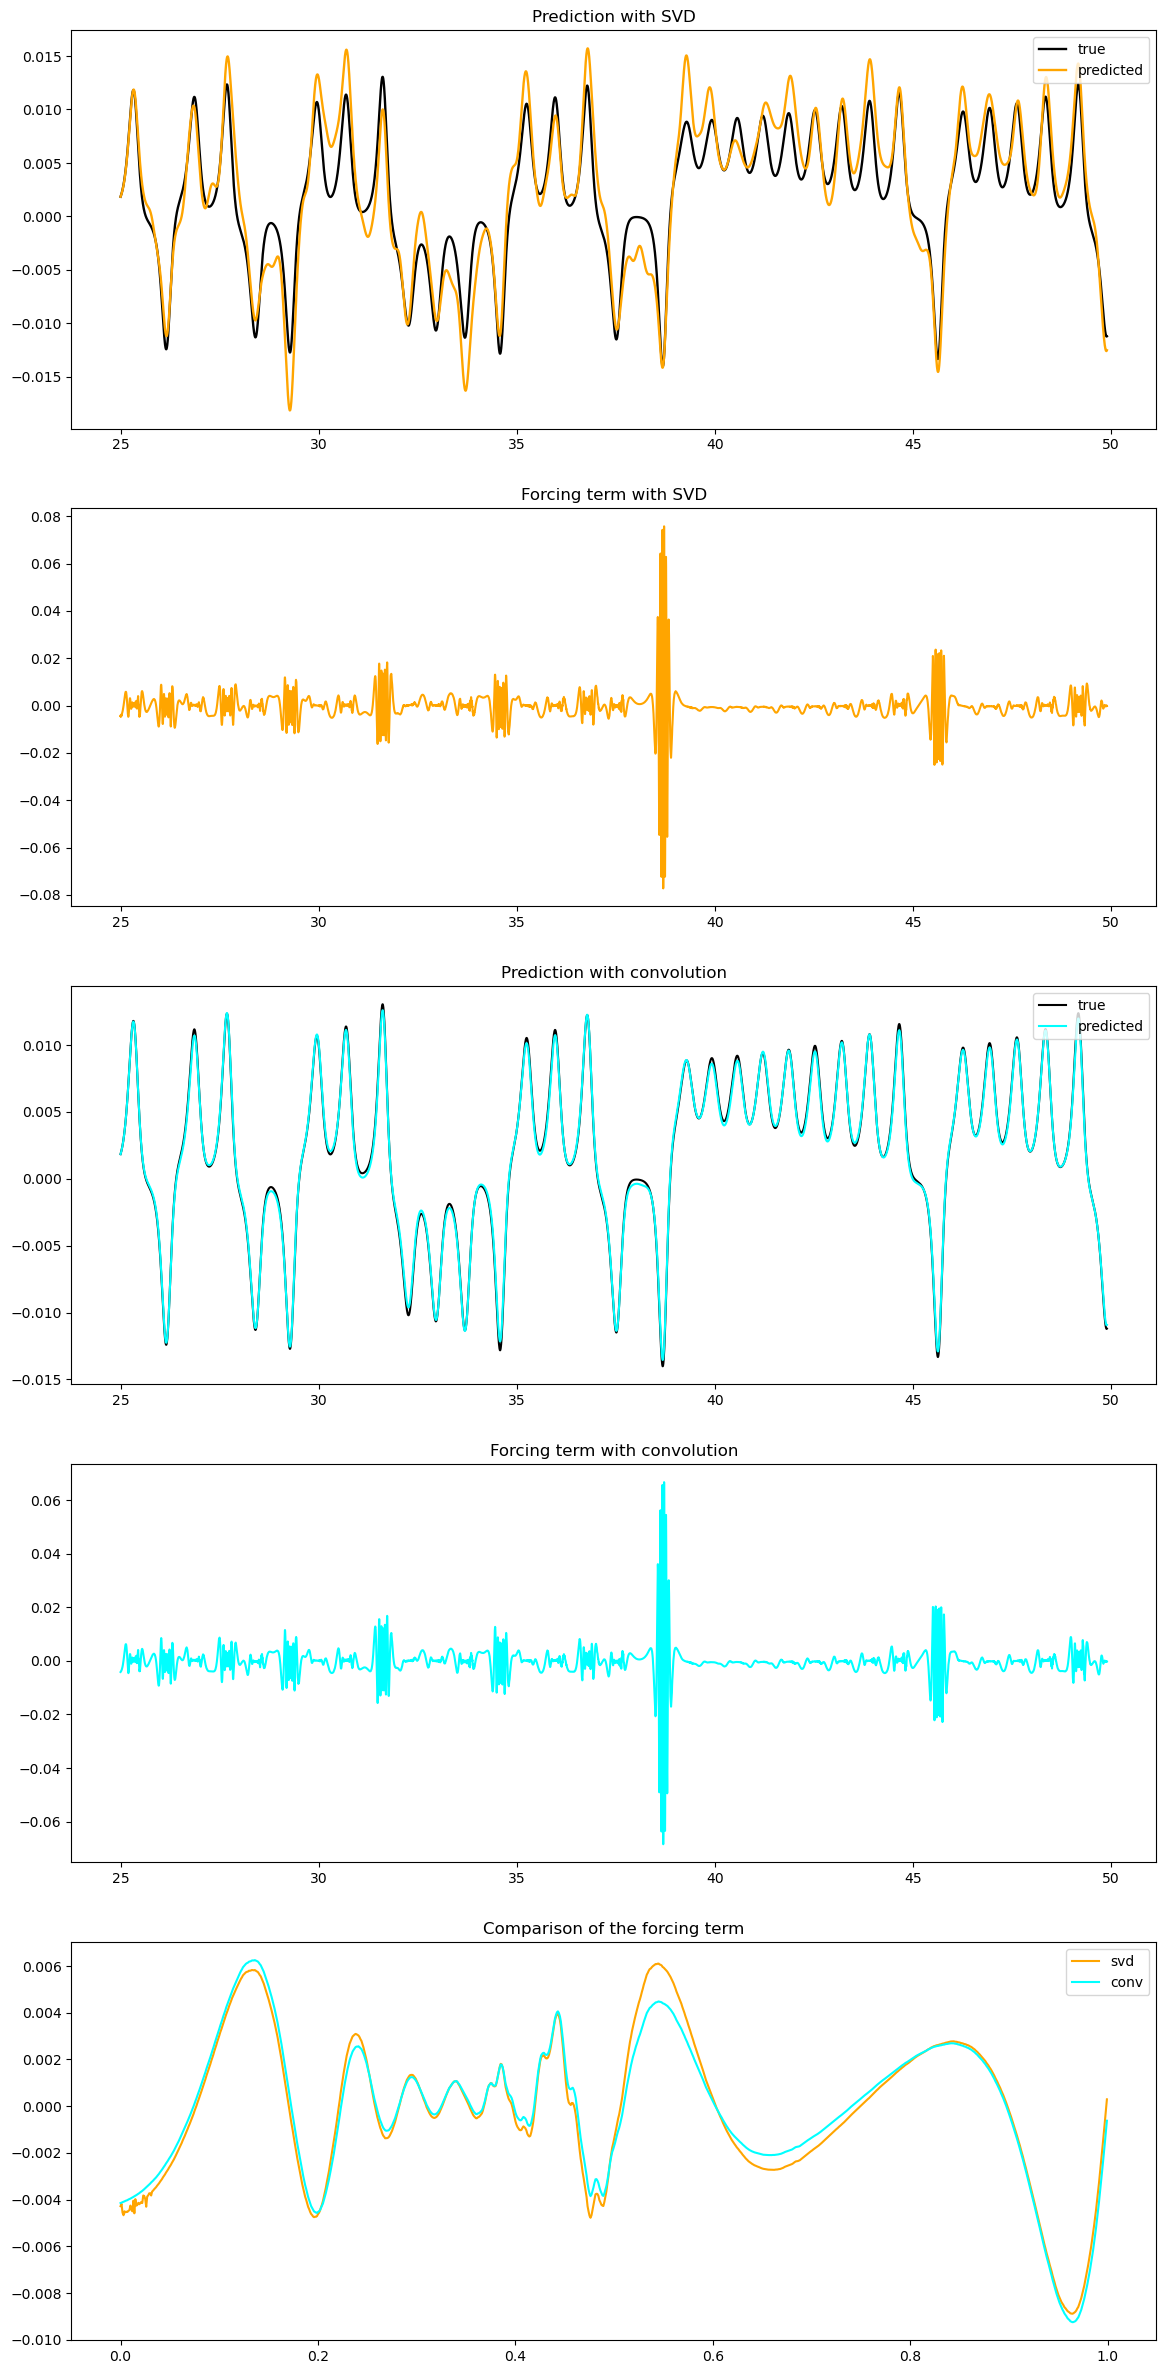

In [17]:
fig, ax = plt.subplots(5,1, figsize = (14,30))
ax[0].set_title('Prediction with SVD')
ax[0].plot(time[n_train:n_train+L],v_test[:,0][0:L], lw = 1.7,c='black')
ax[0].plot(time[n_train:n_train+L],y1_svd[0:L],lw = 1.7,c='orange')
ax[0].legend(['true','predicted'],loc='upper right')
ax[1].set_title('Forcing term with SVD')
ax[1].plot(time[n_train:n_train+L],f_svd,c='orange')

ax[2].set_title('Prediction with convolution')
ax[2].plot(time[n_train:n_train+L],v_test[:L,0],c='black')
ax[2].plot(time[n_train:n_train+L],y1_conv[:L],c='cyan')
ax[2].legend(['true','predicted'],loc='upper right')
ax[3].set_title('Forcing term with convolution')
ax[3].plot(time[n_train:n_train+L],f_conv,c='cyan')

ax[4].set_title('Comparison of the forcing term')
ax[4].plot(time[0:1000],f_svd[0:1000],c='orange')
ax[4].plot(time[0:1000],f_conv[0:1000],c='cyan')
ax[4].legend(['svd','conv'],loc='upper right')

### Threshold

In [18]:
def find_period(V,t):
    from scipy import fftpack

    dt = t[1] - t[0]
    sig = V
    sig = sig[sig > 0]
    sig -= np.mean(sig)
    sig_fft = fftpack.fft(sig)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(sig.size, d=dt)
    freqs = sample_freq[np.where(sample_freq > 0)]
    powes = power[np.where(sample_freq > 0)]
    peak_freq = freqs[powes.argmax()]
    period1 = 1/peak_freq
    
    sig = V
    sig = sig[sig < 0]
    sig -= np.mean(sig)
    sig_fft = fftpack.fft(sig)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(sig.size, d=dt)
    freqs = sample_freq[np.where(sample_freq > 0)]
    powes = power[np.where(sample_freq > 0)]
    peak_freq = freqs[powes.argmax()]
    period2 = 1/peak_freq
    
    return (period1 + period2)/2

period = find_period(v[:,0],time)
print(period)

def thresh(Vr, V, t, period, thresh_r, consult=False, plot=False, dplot=False):
    period = int(period/(t[1] - t[0]))
    skip = int(6*period/8)
    mask = np.abs(Vr) > thresh_r
    
    i = 0
    prec = i
    while i < len(mask) - skip:
        if mask[i] == True:
            if consult == True: print(t[i],np.abs(Vr[i]))
            else:
                mask[i:i+skip] = [True for i in range(skip)]
            i += skip
        i += 1
    
    not_mask = [not x for x in mask]
    
    if plot == True:
        v_lin = np.copy(V[:,0])
        v_lin[mask] = np.nan
        v_for = np.copy(V[:,0])
        v_for[not_mask] = np.nan

        vr_lin = np.copy(Vr)
        vr_lin[mask] = np.nan
        vr_for = np.copy(Vr)
        vr_for[not_mask] = np.nan

        x = [t[1000*i] for i in range(int(len(t)/1000))]

        fig, ax = plt.subplots(2,1,figsize=(16,12))
        ax[0].plot(t,v_lin,c='black')
        ax[0].plot(t,v_for,c='red')
        ax[0].axhline(0,lw=0.5,c="dimgrey")
        ax[0].axhline(thresh_0,lw=0.5,c="darkred",ls='--')
        ax[0].axhline(-thresh_0,lw=0.5,c="darkred",ls='--')
        ax[0].set_xticks(x)
        ax[1].plot(t,vr_lin,c='black')
        ax[1].plot(t,vr_for,c='red')
        ax[1].axhline(thresh_r,lw=0.5,c="darkred",ls='--')
        ax[1].axhline(-thresh_r,lw=0.5,c="darkred",ls='--')
        ax[1].set_ylim(-0.05,0.05)
    
    if dplot == True:
        v_lin0 = np.copy(V[:,0])
        v_lin0[mask] = np.nan
        v_lin1 = np.copy(V[:,1])
        v_lin1[mask] = np.nan
        v_lin2 = np.copy(V[:,2])
        v_lin2[mask] = np.nan
        v_for0 = np.copy(V[:,0])
        v_for0[not_mask] = np.nan
        v_for1 = np.copy(V[:,1])
        v_for1[not_mask] = np.nan
        v_for2 = np.copy(V[:,2])
        v_for2[not_mask] = np.nan
        
        plt.figure(figsize = (8,8))
        ax = plt.axes(projection='3d')
        ax.plot3D(v_lin0,v_lin1,v_lin2,c='black')
        ax.plot3D(v_for0,v_for1,v_for2,c='red')
        plt.show()

    return mask, not_mask

0.754016346153846


(-0.025, 0.025)

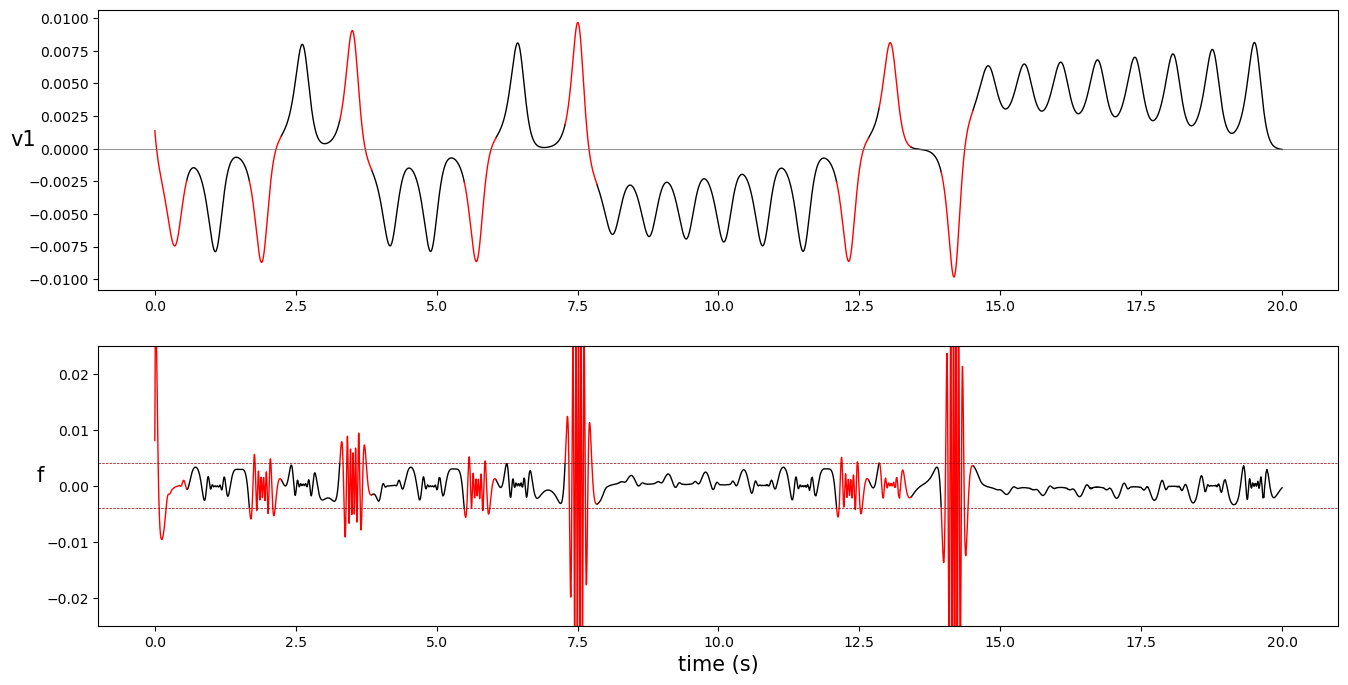

In [19]:
thresh_r=0.004
mask, not_mask = thresh(v[:,-1],v[:,:r-1],time,thresh_r=thresh_r,period=period)

v_lin = np.copy(v[:,0])
v_lin[mask] = np.nan
v_for = np.copy(v[:,0])
v_for[not_mask] = np.nan

vr_lin = np.copy(v[:,-1])
vr_lin[mask] = np.nan
vr_for = np.copy(v[:,-1])
vr_for[not_mask] = np.nan

csfont = {'fontname' : 'Century Schoolbook', 'fontsize' : '15'}

fig, ax = plt.subplots(2,1,figsize=(16,8))
ax[0].plot(time[:20000],v_lin[:20000],c='black',lw=1)
ax[0].plot(time[:20000],v_for[:20000],c='red',lw=1)
ax[0].axhline(0,lw=0.5,c="dimgrey")
ax[0].set_ylabel('v1',rotation=0,**csfont)
ax[1].plot(time[:20000],vr_lin[:20000],c='black',lw=1)
ax[1].plot(time[:20000],vr_for[:20000],c='red',lw=1)
ax[1].axhline(thresh_r,lw=0.5,c="darkred",ls='--')
ax[1].axhline(-thresh_r,lw=0.5,c="darkred",ls='--')
ax[1].set_ylabel('f',rotation=0,**csfont)
ax[1].set_xlabel('time (s)',rotation=0,**csfont)
ax[1].set_ylim(-0.025,0.025)

### Threshold with NN

In [20]:
x_train_NN = np.copy(v_conv)
n_train_NN = len(v_conv)
##Label set creation
period_NN = int(period/(time[1] - time[0]))
x_lab_NN = np.zeros(n_train_NN)
for i in range(1,n_train_NN):
    if np.sign(x_train_NN[i,0]) != np.sign(x_train_NN[i-1,0]):
        if i < period_NN: x_lab_NN[:i] = 1
        else: x_lab_NN[i-period_NN:i] = 1

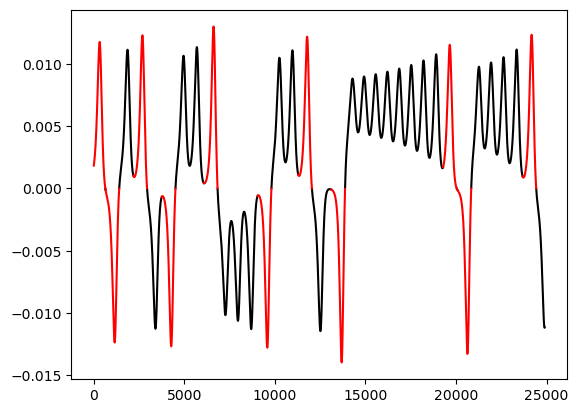

In [21]:
mask = x_lab_NN == 1
not_mask = [not x for x in mask]

v_lin1 = np.copy(x_train_NN[:,0])
v_lin1[mask] = np.nan

vr_lin1 = np.copy(x_train_NN[:,0])
vr_lin1[not_mask] = np.nan

plt.plot(v_lin1,c='black')
plt.plot(vr_lin1,c='red')

In [22]:
model = Sequential()
model.add(Dense(r,input_shape = (r,), activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

compile_model = model.compile(loss = 'binary_crossentropy',
                             optimizer = 'Nadam',
                             metrics = ['accuracy'])

nepochs = 100

fit = model.fit(x_train_NN, x_lab_NN, epochs = nepochs, batch_size = 50,
               verbose = 2)

2023-03-01 19:09:38.676660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-01 19:09:38.676803: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-01 19:09:38.676891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-T351G019): /proc/driver/nvidia/version does not exist
2023-03-01 19:09:38.678543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
498/498 - 7s - loss: 0.6247 - accuracy: 0.6728 - 7s/epoch - 14ms/step
Epoch 2/100
498/498 - 3s - loss: 0.5609 - accuracy: 0.7106 - 3s/epoch - 6ms/step
Epoch 3/100
498/498 - 4s - loss: 0.4801 - accuracy: 0.7857 - 4s/epoch - 7ms/step
Epoch 4/100
498/498 - 4s - loss: 0.4116 - accuracy: 0.8302 - 4s/epoch - 7ms/step
Epoch 5/100
498/498 - 3s - loss: 0.3674 - accuracy: 0.8503 - 3s/epoch - 6ms/step
Epoch 6/100
498/498 - 3s - loss: 0.3430 - accuracy: 0.8626 - 3s/epoch - 6ms/step
Epoch 7/100
498/498 - 3s - loss: 0.3314 - accuracy: 0.8693 - 3s/epoch - 7ms/step
Epoch 8/100
498/498 - 3s - loss: 0.3222 - accuracy: 0.8739 - 3s/epoch - 5ms/step
Epoch 9/100
498/498 - 3s - loss: 0.3168 - accuracy: 0.8755 - 3s/epoch - 6ms/step
Epoch 10/100
498/498 - 3s - loss: 0.3121 - accuracy: 0.8762 - 3s/epoch - 5ms/step
Epoch 11/100
498/498 - 3s - loss: 0.3084 - accuracy: 0.8777 - 3s/epoch - 6ms/step
Epoch 12/100
498/498 - 3s - loss: 0.3045 - accuracy: 0.8798 - 3s/epoch - 6ms/step
Epoch 13/100
498/498 - 3

In [23]:
eval_train = model.evaluate(x_train_NN, x_lab_NN)
print('loss: ', eval_train[0], 'acc: ', eval_train[1])

779/779 [==============================] - 5s 6ms/step - loss: 0.1135 - accuracy: 0.9529
loss:  0.11347848176956177 acc:  0.952851414680481


Now we apply convolution to a new test set and test the accuracy of our model.

Text(0, 0.5, 'x')

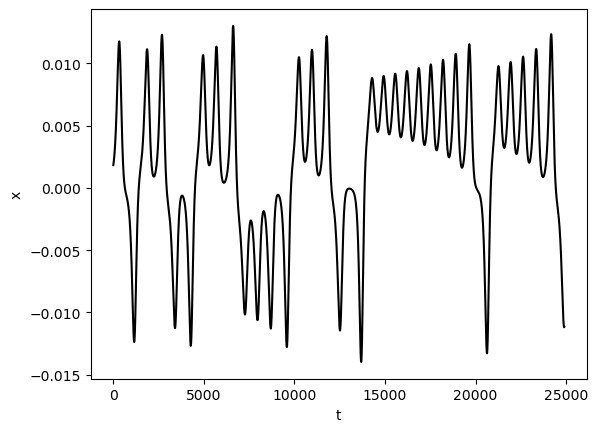

In [24]:
x_test_NN = x_ts[len(x_train):]
q = 100
U1 = U_train[:,:r]
Vt_conv_test = np.zeros((r,len(x_test_NN)-100))
for i in range(0,len(x_test_NN)-100):
    Vt_conv_test[:,i] = np.dot(x_test_NN[i:i+q],U1)

v_conv_test = Vt_conv_test[:r,:].T
for i in range(r): v_conv_test[:,i] = v_conv_test[:,i]/spectrum_train[i]
    
x_test_NN = np.copy(v_conv_test)

plt.plot(x_test_NN[:,0],c='black')
plt.xlabel("t")
plt.ylabel("x")

779/779 [==============================] - 4s 5ms/step


Text(0.5, 0, 't')

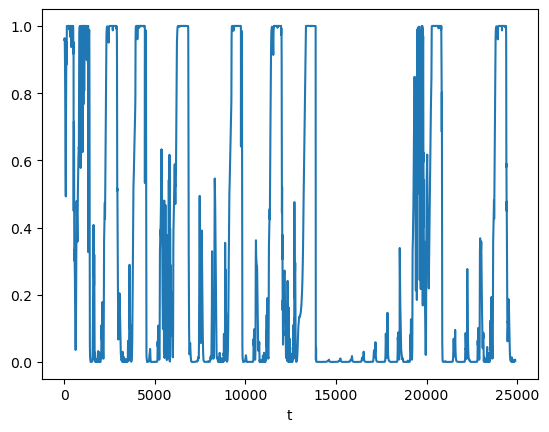

In [25]:
x_lab_test = model.predict(x_test_NN)
plt.plot(x_lab_test)
plt.xlabel("t")

Text(0, 0.5, 'x')

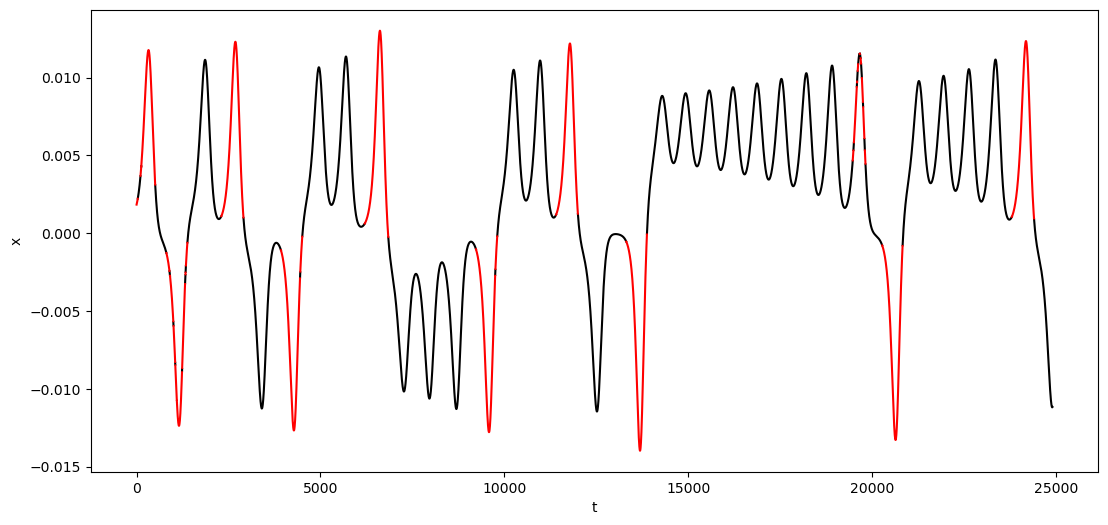

In [26]:
mask = np.reshape(x_lab_test > 0.9,(len(mask),))
not_mask = [not x for x in mask]

v_lin1_t = np.copy(x_test_NN[:,0])
v_lin1_t[mask] = np.nan

vr_lin1_t = np.copy(x_test_NN[:,0])
vr_lin1_t[not_mask] = np.nan

plt.figure(figsize = (13,6))
plt.plot(v_lin1_t,c='black')
plt.plot(vr_lin1_t,c='red')
plt.xlabel("t")
plt.ylabel("x")